# Card steering wheel angle

## Problem definition

The challenge is to predict a car steering whell angles given a video captured from car front center position.

In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
np.random.seed(42)

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
from lib.services import config
from lib.data_set_source import DataSetSource
from lib.data_set import DataSet
from lib.image_utils import route_area

### Load raw data and create datasets

Define image processor: This processor chop image to get ony route.

In [3]:
image_processor = lambda image: route_area(
    image, 
    config['data_set']['image']['width'], 
    config['data_set']['image']['height'],  
    config['data_set']['image']['board_height']
)

In [4]:
data_set_source = DataSetSource(config['data_set']['path'])

#### Show examples

Load train data

In [5]:
train_set = data_set_source.load(
    epochs=config['data_set']['epochs']['train'],
    flip_features=True,
    feature_processor=image_processor,
    data_set_name='train'
)

Loading epochs... 1 2 3 4 5 6 7 8 9
Flipping features...
Data set loaded! DataSet(name: train, features.shape: (48600, 66, 200, 3), labels.shape: (48600, 1))


Rigth curve example:

Angle: [5.]


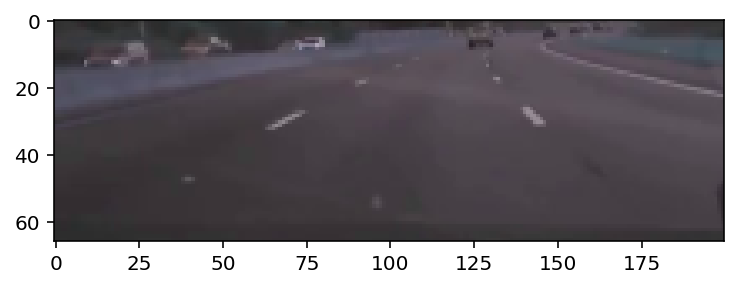

In [6]:
train_set.plot_example(2000)

Example with road in a straight line: 

Angle: [0.]


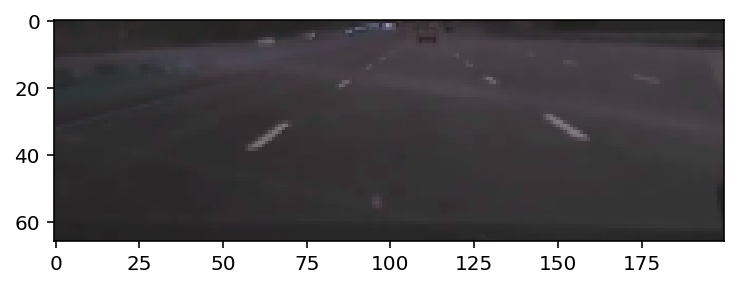

In [7]:
train_set.plot_example(100)

Left curve example:

Angle: [1.5]


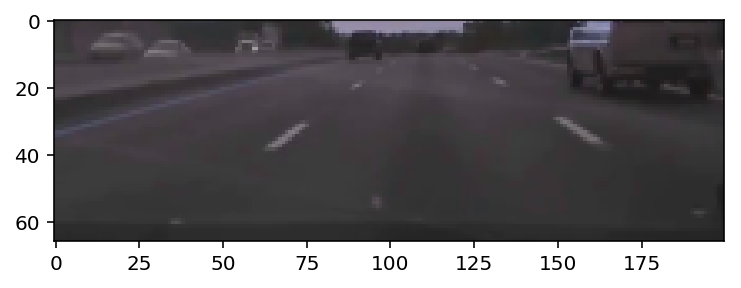

In [8]:
train_set.plot_example(8000)

In [9]:
test_set = data_set_source.load(
    epochs=config['data_set']['epochs']['test'], 
    flip_features=True,
    feature_processor=image_processor,
    data_set_name='test'
)

Loading epochs... 10
Flipping features...
Data set loaded! DataSet(name: test, features.shape: (5400, 66, 200, 3), labels.shape: (5400, 1))


In [10]:
train_set.save()
test_set.save()

Train data set:
 - features saved!
 - labels saved!
Test data set:
 - features saved!
 - labels saved!


### Load dataset

In [11]:
from lib.services import config
from lib.data_set import DataSet

train_set = DataSet.load('train')
test_set = DataSet.load('test')

Data set loaded! DataSet(name: train, features.shape: (48600, 66, 200, 3), labels.shape: (48600, 1))
Data set loaded! DataSet(name: test, features.shape: (5400, 66, 200, 3), labels.shape: (5400, 1))


In [12]:
train_set, validation_set = train_set.split(
    split_percent=config['train']['validation_set_size'],
    shuffle=True,
    name='validation'
)

Split train data set into (split percent: 0.2 %):
 - DataSet(name: train, features.shape: (38880, 66, 200, 3), labels.shape: (38880, 1))
 - DataSet(name: validation, features.shape: (9720, 66, 200, 3), labels.shape: (9720, 1))


### Build Model

In [19]:
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, Conv2D, MaxPooling2D, Input, Reshape
from keras.layers.normalization import BatchNormalization
from keras import losses, regularizers

import lib.plot_utils as plot_utils
from lib.model_wrapper import ModelWrapper
from lib.model_builder import build_model
from lib.services import config

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Lambda_Layer (Lambda)  (None, 66, 200, 3)        0         
_________________________________________________________________
Convolutional_2D_Layer_1 (Co (None, 66, 200, 24)       672       
_________________________________________________________________
Batch_Normalization_Layer_1  (None, 66, 200, 24)       96        
_________________________________________________________________
Max_Pooling_2D_Layer_1 (MaxP (None, 33, 100, 24)       0         
_________________________________________________________________
Convolutional_2D_Layer_2 (Co (None, 33, 100, 32)       6944      
_________________________________________________________________
Batch_Normalization_Layer_2  (None, 33, 100, 32)       128       
_________________________________________________________________
Max_Pooling_2D_Layer_2 (MaxP (None, 16, 50, 32)        0         
__________

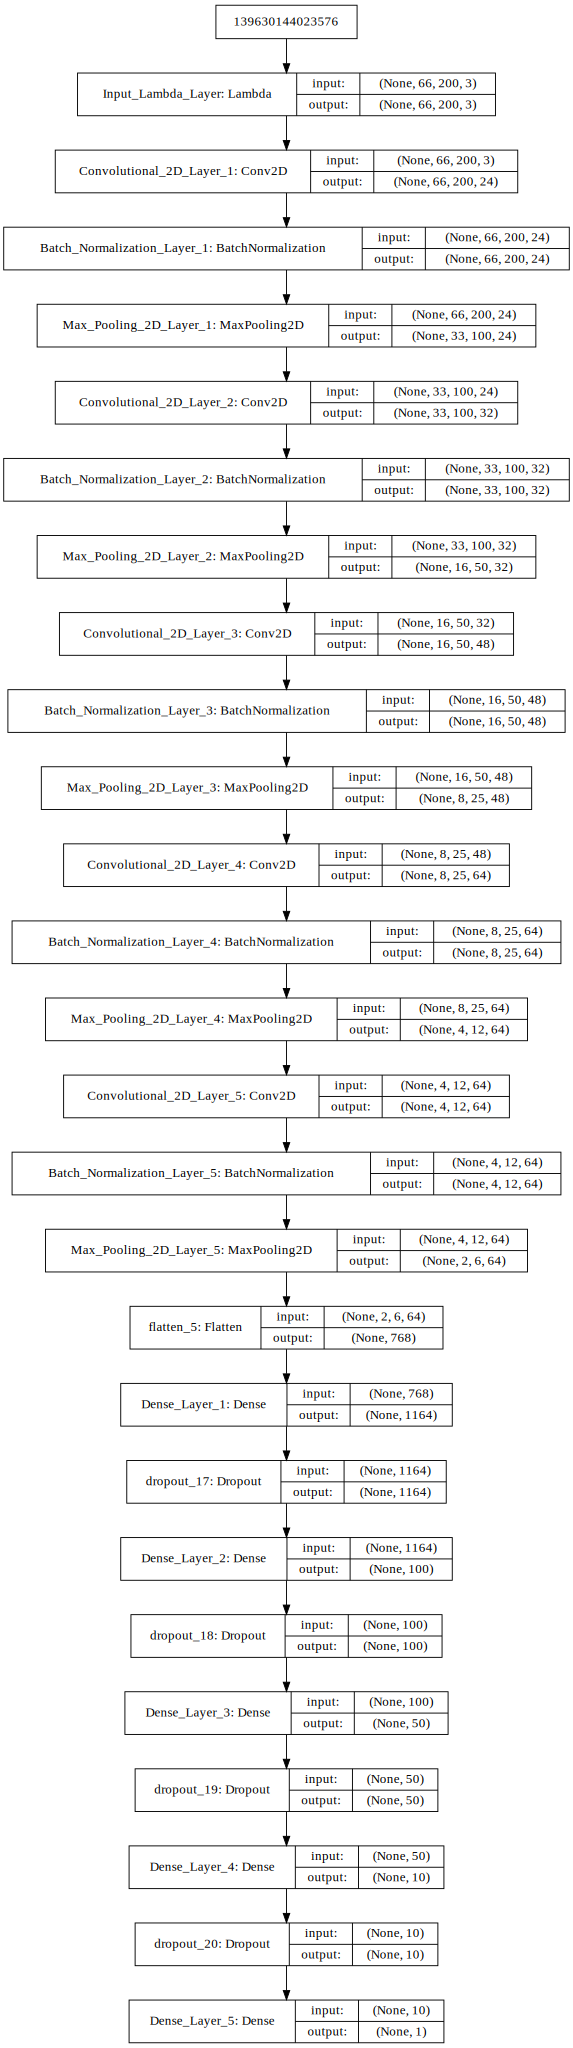

In [20]:
model = ModelWrapper(build_model(config))
model.show()

In [21]:
history = model.train(
    train_set,  validation_set,
    epochs=config['train']['epochs'], 
    batch_size=config['train']['batch_size'],
    shuffle=True
)

Train on 38880 samples, validate on 9720 samples
Epoch 1/20
38880/38880 [==============================] - 34s 885us/step - loss: 22.4378 - val_loss: 21.5528
Epoch 2/20
38880/38880 [==============================] - 29s 738us/step - loss: 19.1108 - val_loss: 15.6032
Epoch 3/20
38880/38880 [==============================] - 29s 747us/step - loss: 14.3198 - val_loss: 14.3180
Epoch 4/20
38880/38880 [==============================] - 30s 766us/step - loss: 12.4365 - val_loss: 10.7349
Epoch 5/20
38880/38880 [==============================] - 29s 740us/step - loss: 11.6614 - val_loss: 10.0535
Epoch 6/20
38880/38880 [==============================] - 30s 778us/step - loss: 11.2079 - val_loss: 9.7339
Epoch 7/20
38880/38880 [==============================] - 28s 727us/step - loss: 10.8769 - val_loss: 9.5011
Epoch 8/20
38880/38880 [==============================] - 29s 757us/step - loss: 10.6334 - val_loss: 9.3435
Epoch 9/20
38880/38880 [==============================] - 29s 752us/step - loss: 1

dict_keys(['val_loss', 'loss'])


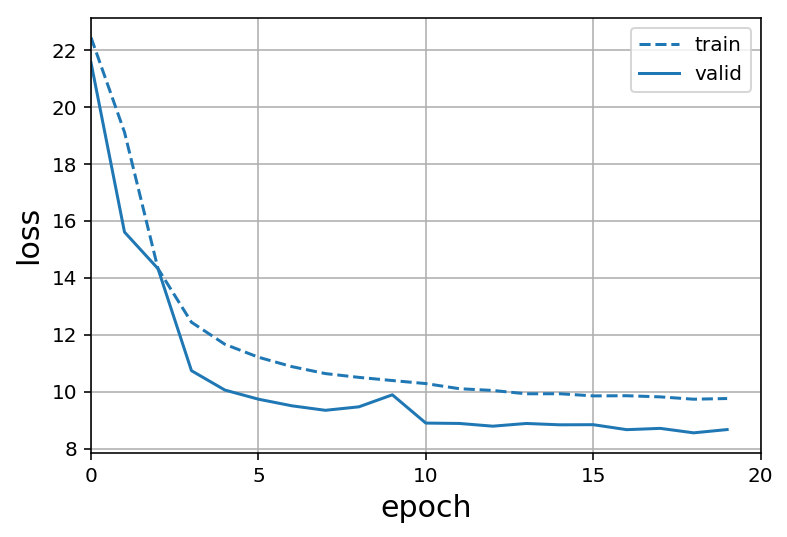

In [22]:
plot_utils.plot_loss(history)

In [23]:
model.evaluate(test_set, batch_size=config['train']['batch_size'])

5400/5400 [==============================] - 2s 372us/step
Loss: 4.833210016179968


In [24]:
model.save()